# Beat CRNN MVP Training

Notebook version of `scripts/train_beat_mvp.py`. This reproduces the original script with sectioned code cells for interactive use.


## Configuration and Imports


In [14]:
import json
import math
import os
from typing import List, Tuple

import librosa
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

TARGET_SR = 44100
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512  # ~11.6 ms at 44.1k
BEAT_TOLERANCE_SEC = 0.03  # +/- 30 ms


## Label Utilities


In [2]:
def load_label_json(label_path: str) -> dict:
    with open(label_path, "r") as f:
        return json.load(f)


def generate_beats_from_constant_bpm(
    bpm: float,
    duration: float,
    downbeat_offset_sec: float = 0.0,
) -> List[float]:
    """Generate a simple beatgrid for a constant-BPM track."""
    if bpm is None or bpm <= 0:
        return []

    period = 60.0 / float(bpm)  # seconds per beat
    beat_times = []

    t = downbeat_offset_sec
    while t < duration:
        beat_times.append(t)
        t += period

    return beat_times


## Audio to Mel Features


In [3]:
def load_audio_to_mel(audio_path: str):
    """Load audio to mono log-mel spectrogram and frame timestamps."""
    y, sr = librosa.load(audio_path, sr=TARGET_SR, mono=True)
    duration = len(y) / sr

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        power=2.0,
    )
    mel_db = librosa.power_to_db(mel, ref=np.max).T  # (T, N_MELS)

    frames = np.arange(mel_db.shape[0])
    frame_times = librosa.frames_to_time(
        frames,
        sr=sr,
        hop_length=HOP_LENGTH,
        n_fft=N_FFT,
    )

    return mel_db, frame_times, duration


def beat_times_to_frame_labels(
    beat_times: List[float],
    frame_times: np.ndarray,
    tolerance_sec: float = BEAT_TOLERANCE_SEC,
) -> np.ndarray:
    """Convert beat timestamps to per-frame binary labels."""
    labels = np.zeros_like(frame_times, dtype=np.float32)

    if len(beat_times) == 0:
        return labels

    beat_idx = 0
    num_beats = len(beat_times)

    for i, ft in enumerate(frame_times):
        while beat_idx + 1 < num_beats and beat_times[beat_idx] < ft:
            if abs(beat_times[beat_idx + 1] - ft) < abs(beat_times[beat_idx] - ft):
                beat_idx += 1
            else:
                break
        if abs(beat_times[beat_idx] - ft) <= tolerance_sec:
            labels[i] = 1.0

    return labels


## Dataset


In [17]:
class BeatActivationDataset(Dataset):
    """Dataset returning full-track mel tensors and beat labels."""

    def __init__(self, items: List[dict]):
        self.items = items

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]
        audio_path = item["audio_path"]
        label_path = item["label_path"]

        mel_db, frame_times, duration_audio = load_audio_to_mel(audio_path)

        label_json = load_label_json(label_path)
        bpm = float(label_json["bpm"])
        duration_label = float(label_json.get("duration", duration_audio))
        downbeat_offset = float(label_json.get("downbeatOffset", 0))

        beat_times = generate_beats_from_constant_bpm(
            bpm=bpm,
            duration=duration_label,
            downbeat_offset_sec=downbeat_offset,
        )

        labels = beat_times_to_frame_labels(beat_times, frame_times)

        mel_tensor = torch.from_numpy(mel_db).float()
        labels_tensor = torch.from_numpy(labels).float()

        labels = beat_times_to_frame_labels(beat_times, frame_times)
        pos_ratio = labels.mean()
        print(f"{audio_path} - positive frame ratio: {pos_ratio:.4f}")


        return mel_tensor, labels_tensor


def collate_full_tracks(batch):
    """Simple collate that stacks mels/labels (assumes equal lengths)."""
    mels = [b[0] for b in batch]
    labels = [b[1] for b in batch]

    mel_batch = torch.stack(mels, dim=0)
    label_batch = torch.stack(labels, dim=0)

    return mel_batch, label_batch


## Model


In [5]:
class BeatCRNN(nn.Module):
    """Minimal CRNN mapping log-mels to beat logits."""

    def __init__(self, n_mels=N_MELS, hidden_size=128, num_layers=2):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
        )

        freq_out = n_mels // 4
        cnn_channels = 64
        rnn_input_size = cnn_channels * freq_out

        self.rnn = nn.LSTM(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )

        self.output = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        """Forward pass producing beat logits."""
        B, T, F = x.shape
        x = x.unsqueeze(1)
        x = self.cnn(x)
        B, C, T_new, F_new = x.shape
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(B, T_new, C * F_new)
        x, _ = self.rnn(x)
        logits = self.output(x).squeeze(-1)
        return logits


## Training Loop


In [6]:
def train_mvp(
    train_items: List[dict],
    val_items: List[dict] = None,
    num_epochs: int = 20,
    lr: float = 1e-3,
    device: str = None,
):
    """Train the Beat CRNN on full tracks."""
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    train_ds = BeatActivationDataset(train_items)
    train_loader = DataLoader(
        train_ds,
        batch_size=1,
        shuffle=True,
        collate_fn=collate_full_tracks,
    )

    if val_items is not None and len(val_items) > 0:
        val_ds = BeatActivationDataset(val_items)
        val_loader = DataLoader(
            val_ds,
            batch_size=1,
            shuffle=False,
            collate_fn=collate_full_tracks,
        )
    else:
        val_loader = None

    model = BeatCRNN().to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0

        for mel_batch, label_batch in train_loader:
            mel_batch = mel_batch.to(device)
            label_batch = label_batch.to(device)

            optim.zero_grad()
            logits = model(mel_batch)

            T_pred = logits.shape[1]
            T_true = label_batch.shape[1]
            T_min = min(T_pred, T_true)

            loss = criterion(
                logits[:, :T_min],
                label_batch[:, :T_min],
            )
            loss.backward()
            optim.step()

            total_loss += loss.item()

        avg_loss = total_loss / max(1, len(train_loader))
        print(f"Epoch {epoch}/{num_epochs} - Train loss: {avg_loss:.4f}")

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for mel_batch, label_batch in val_loader:
                    mel_batch = mel_batch.to(device)
                    label_batch = label_batch.to(device)

                    logits = model(mel_batch)
                    T_pred = logits.shape[1]
                    T_true = label_batch.shape[1]
                    T_min = min(T_pred, T_true)

                    loss = criterion(
                        logits[:, :T_min],
                        label_batch[:, :T_min],
                    )
                    val_loss += loss.item()

            avg_val_loss = val_loss / max(1, len(val_loader))
            print(f"           Val loss:   {avg_val_loss:.4f}")

    return model


## Testing/ Investigation 


In [15]:
def inspect_track(model, audio_path, bpm, downbeat_offset=0.0):
    model.eval()
    device = next(model.parameters()).device

    # 1) Audio -> mel
    mel_db, frame_times, duration = load_audio_to_mel(audio_path)

    # 2) Generate ground truth beats (same function you used for training)
    beat_times = generate_beats_from_constant_bpm(
        bpm=bpm,
        duration=duration,
        downbeat_offset_sec=downbeat_offset,
    )

    # 3) Model prediction
    with torch.no_grad():
        x = torch.from_numpy(mel_db).float().unsqueeze(0).to(device)  # (1, T, F)
        logits = model(x)  # (1, T')
        probs = torch.sigmoid(logits).cpu().numpy()[0]  # (T',)

    # Make frame_times match probs length (due to CNN pooling)
    T_pred = probs.shape[0]
    frame_times_pred = frame_times[:T_pred]

    # 4) Plot
    plt.figure(figsize=(14, 5))
    plt.plot(frame_times_pred, probs, label="beat_prob")
    for bt in beat_times:
        if bt <= frame_times_pred[-1]:
            plt.axvline(bt, color="r", alpha=0.2)  # ground truth beats

    plt.xlabel("Time (s)")
    plt.ylabel("Beat probability")
    plt.title("Beat activation vs ground truth beats")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Example Usage


In [12]:
os.chdir("..")
train_items = [
    {
        "audio_path": "data/audio/ASCENSION.mp3",
        "label_path": "data/labels/ASCENSION.labels.json",
    },
    {
        "audio_path": "data/audio/BREATH_LESS.mp3",
        "label_path": "data/labels/BREATH_LESS.labels.json",
    },
    {
        "audio_path": "data/audio/Burn The Evidence.mp3",
        "label_path": "data/labels/Burn The Evidence.labels.json",
    },
    {
        "audio_path": "data/audio/City Lights.mp3",
        "label_path": "data/labels/City Lights.labels.json",
    },
    {
        "audio_path": "data/audio/END OF THE STORY.mp3",
        "label_path": "data/labels/END OF THE STORY.labels.json",
    },
    {
        "audio_path": "data/audio/GHOST.mp3",
        "label_path": "data/labels/GHOST.labels.json",
    }
]

print("=== Overfitting on 1 track ===")
model = train_mvp(train_items=train_items[:1], val_items=None, num_epochs=30)

print("=== Training on all tracks (simple val on last) ===")
model = train_mvp(
    train_items=train_items[:-1],
    val_items=train_items[-1:],
    num_epochs=30,
)

torch.save(model.state_dict(), "beat_crnn_mvp.pth")


=== Overfitting on 1 track ===
Using device: cpu
Epoch 1/30 - Train loss: 0.7084
Epoch 2/30 - Train loss: 0.4957
Epoch 3/30 - Train loss: 0.4409
Epoch 4/30 - Train loss: 0.4497
Epoch 5/30 - Train loss: 0.4548
Epoch 6/30 - Train loss: 0.4481
Epoch 7/30 - Train loss: 0.4410
Epoch 8/30 - Train loss: 0.4381
Epoch 9/30 - Train loss: 0.4394
Epoch 10/30 - Train loss: 0.4417
Epoch 11/30 - Train loss: 0.4425
Epoch 12/30 - Train loss: 0.4414
Epoch 13/30 - Train loss: 0.4395
Epoch 14/30 - Train loss: 0.4379
Epoch 15/30 - Train loss: 0.4369
Epoch 16/30 - Train loss: 0.4367
Epoch 17/30 - Train loss: 0.4370
Epoch 18/30 - Train loss: 0.4372
Epoch 19/30 - Train loss: 0.4369
Epoch 20/30 - Train loss: 0.4362
Epoch 21/30 - Train loss: 0.4352
Epoch 22/30 - Train loss: 0.4342
Epoch 23/30 - Train loss: 0.4333
Epoch 24/30 - Train loss: 0.4324
Epoch 25/30 - Train loss: 0.4313
Epoch 26/30 - Train loss: 0.4300
Epoch 27/30 - Train loss: 0.4284
Epoch 28/30 - Train loss: 0.4263
Epoch 29/30 - Train loss: 0.4240
Epo

In [18]:
def inspect_track_zoom(model, audio_path, bpm, downbeat_offset=0.0,
                       t_start=40.0, t_end=50.0):
    model.eval()
    device = next(model.parameters()).device

    mel_db, frame_times, duration = load_audio_to_mel(audio_path)

    beat_times = generate_beats_from_constant_bpm(
        bpm=bpm,
        duration=duration,
        downbeat_offset_sec=downbeat_offset,
    )

    with torch.no_grad():
        x = torch.from_numpy(mel_db).float().unsqueeze(0).to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    T_pred = probs.shape[0]
    frame_times_pred = frame_times[:T_pred]

    # mask to window
    mask = (frame_times_pred >= t_start) & (frame_times_pred <= t_end)
    ft_win = frame_times_pred[mask]
    probs_win = probs[mask]

    plt.figure(figsize=(10, 4))
    plt.plot(ft_win, probs_win, label="beat_prob")

    # draw grid beats in this window
    for bt in beat_times:
        if t_start <= bt <= t_end:
            plt.axvline(bt, color="r", alpha=0.4)

    plt.xlabel("Time (s)")
    plt.ylabel("Beat probability")
    plt.title(f"Beat activation {t_start:.1f}–{t_end:.1f}s")
    plt.legend()
    plt.tight_layout()
    plt.show()



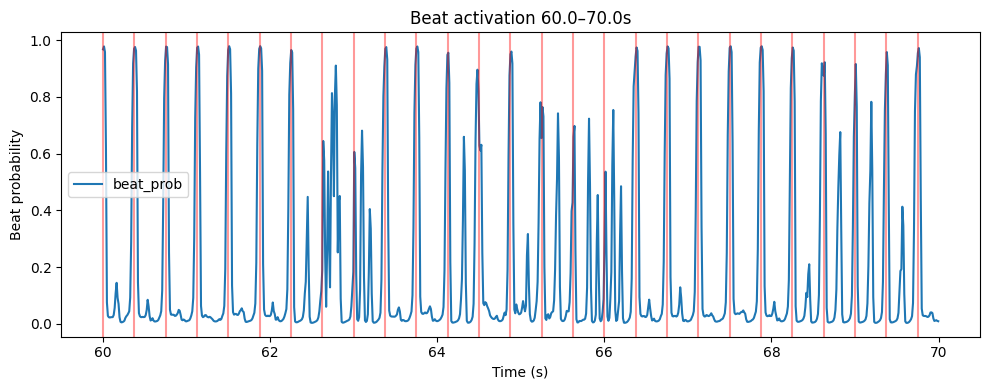

In [27]:
inspect_track_zoom(model, "data/audio/ASCENSION.mp3",
                   bpm=160, downbeat_offset=0.0,
                   t_start=60.0, t_end=70.0)


In [20]:
from scipy.signal import find_peaks
import numpy as np

def extract_predicted_beats(frame_times, probs, threshold=0.5, distance_frames=3):
    """
    Use simple peak picking to turn beat_prob into beat times.
    """
    peaks, _ = find_peaks(probs, height=threshold, distance=distance_frames)
    return frame_times[peaks]


def match_beats(true_beats, pred_beats, tol=0.05):
    """
    true_beats, pred_beats: 1D np.arrays of times in seconds
    tol: tolerance in seconds (e.g. 0.05 = 50ms)

    Returns precision, recall, f1.
    """
    true_beats = np.array(true_beats)
    pred_beats = np.array(pred_beats)

    if len(true_beats) == 0 or len(pred_beats) == 0:
        return 0.0, 0.0, 0.0

    # For each predicted beat, see if there's a true beat within tol
    used_true = np.zeros(len(true_beats), dtype=bool)
    tp = 0

    for pb in pred_beats:
        diffs = np.abs(true_beats - pb)
        min_idx = np.argmin(diffs)
        if diffs[min_idx] <= tol and not used_true[min_idx]:
            tp += 1
            used_true[min_idx] = True

    fp = len(pred_beats) - tp
    fn = len(true_beats) - tp

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return precision, recall, f1


In [21]:
def evaluate_track(model, audio_path, bpm, downbeat_offset=0.0):
    model.eval()
    device = next(model.parameters()).device

    mel_db, frame_times, duration = load_audio_to_mel(audio_path)
    true_beats = generate_beats_from_constant_bpm(
        bpm=bpm,
        duration=duration,
        downbeat_offset_sec=downbeat_offset,
    )

    with torch.no_grad():
        x = torch.from_numpy(mel_db).float().unsqueeze(0).to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    frame_times_pred = frame_times[:len(probs)]
    pred_beats = extract_predicted_beats(frame_times_pred, probs,
                                         threshold=0.5, distance_frames=3)

    precision, recall, f1 = match_beats(true_beats, pred_beats, tol=0.05)
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    return precision, recall, f1


## Evaluate Validation Track


In [26]:
test_item = train_items[-1]
label_meta = load_label_json(test_item["data\audio\ASCENSION.mp3"])

test_bpm = float(label_meta["bpm"])
test_downbeat = float(label_meta.get("downbeatOffset", 0.0))

precision, recall, f1 = evaluate_track(
    model,
    audio_path=test_item["audio_path"],
    bpm=test_bpm,
    downbeat_offset=test_downbeat,
)

precision, recall, f1


KeyError: 'data\x07udio\\ASCENSION.mp3'